# Part 2: Trait Pairs and Local Dependence Analysis

This notebook implements **trait pair analysis** to identify candidate syndromes by finding "patches" where traits show strong local dependence even when globally uncorrelated.

## Strategy:
1. Preprocess traits (log-transform skewed, z-score all)
2. Screen all trait pairs for local dependence
3. Use quantile grid method to find "patches" of strong correlation
4. Identify suspect pairs with weak global but strong local correlation
5. Visualize patches of dependence


## Step 1: Load Data and Libraries
This loads the fly trait data and imports necessary libraries for trait pair analysis and visualization.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy import stats
from scipy.stats import pearsonr
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv("../data/master.dataset.final.v2.csv")
df = df.dropna(axis=1, how='all')
df = df.dropna(axis=0, how='all')

print(f"Loaded {len(df)} species with {len(df.columns)} columns")

df


Loaded 149 species with 104 columns


,Species,th.len.m,th.len.m_se,th.wid.m,th.wid.m_se,th.hei.m,th.hei.m_se,th.vol.m,th.vol.m_se,wing.area.m,...,std.aging.rate.m,life.expectancy.f,life.expectancy.m,net.repro.output,early.repro.output,std.sex.siz.diff,std.aging.rate.bias,life.expectancy.bias,anisogamy,OSR
0,C_procnemis,0.985,0.007,0.683,0.005,0.908,0.009,0.612,0.003,1.360,...,4.39,86.947,122.764,166.0,44.0,-0.002,0.612,-0.498,0.000,-0.498
1,D_acutilabella,1.008,0.006,0.773,0.007,0.955,0.015,0.743,0.005,1.432,...,1.71,9.344,11.576,69.0,25.0,0.278,0.052,-0.309,0.000,2.736
2,D_affinis,0.865,0.007,0.628,0.008,0.850,0.016,0.461,0.004,1.229,...,1.98,73.782,135.774,51.0,29.0,0.335,0.559,-0.880,0.004,1.066
3,D_albomicans,1.250,0.042,0.808,0.009,1.048,0.013,1.057,0.013,1.902,...,4.22,55.969,21.319,343.0,122.0,0.245,-0.294,1.393,0.001,4.032
4,D_aldrichi,1.023,0.013,0.760,0.009,0.975,0.011,0.758,0.005,1.777,...,4.34,88.499,100.969,261.0,122.0,0.274,0.223,-0.190,0.001,0.503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,Z_ghesquierei,1.160,0.013,0.750,0.004,1.055,0.008,0.918,0.004,1.803,...,1.41,307.698,286.228,252.0,63.0,0.211,-0.104,0.104,0.000,3.149
145,Z_indianus,1.190,0.005,0.808,0.006,1.095,0.006,1.052,0.004,2.029,...,4.00,253.156,334.804,481.0,265.0,-0.064,0.371,-0.403,0.003,-0.403
146,Z_kolodkinae,1.298,0.026,0.968,0.021,1.216,0.026,1.529,0.018,2.120,...,2.89,105.269,80.928,250.0,124.0,0.163,-0.242,0.379,0.001,0.379
147,Z_taronus,1.349,0.007,0.908,0.009,1.260,0.008,1.544,0.007,1.992,...,3.95,310.840,358.722,572.0,267.0,-0.073,0.270,-0.207,0.005,2.432


## Step 2: Preprocess Traits
This checks trait distributions, applies log-transformation to skewed traits, and z-scores all numeric traits for fair comparison.


In [4]:
# Prepare numeric trait data (exclude standard error columns)
numeric_cols = df.select_dtypes(include=[np.number]).columns
trait_cols = [col for col in numeric_cols if not col.endswith('_se')]
trait_data = df[trait_cols].copy()

# Handle missing values
trait_data_clean = trait_data.fillna(trait_data.mean())

print(f"Prepared {len(trait_cols)} traits for analysis")

# Check distributions and apply log transformation if needed
def check_skewness(data):
    """Check if data is skewed and needs log transformation"""
    skewness = stats.skew(data.dropna())
    return abs(skewness) > 1.0  # Threshold for skewness

# Apply log transformation to skewed traits
trait_data_processed = trait_data_clean.copy()
log_transformed = []

for trait in trait_cols:
    if check_skewness(trait_data_clean[trait]):
        # Add small constant to avoid log(0)
        min_val = trait_data_clean[trait].min()
        if min_val <= 0:
            trait_data_processed[trait] = np.log(trait_data_clean[trait] - min_val + 1)
        else:
            trait_data_processed[trait] = np.log(trait_data_clean[trait])
        log_transformed.append(trait)

print(f"Applied log transformation to {len(log_transformed)} skewed traits:")
print(log_transformed[:10])  # Show first 10

# Z-score all traits
scaler = StandardScaler()
trait_data_zscored = pd.DataFrame(
    scaler.fit_transform(trait_data_processed),
    columns=trait_cols,
    index=trait_data_processed.index
)

print(f"\\nZ-scored all traits (mean=0, std=1)")
print(f"Final data shape: {trait_data_zscored.shape}")


Prepared 70 traits for analysis
Applied log transformation to 36 skewed traits:
['th.vol.m', 'tot.dry.mass.m', 'sp.total.len', 'testis.len', 'agland.area', 'eb.extn_bin', 'eb.extn.branched_bin', 'eb.extn.len', 'eb.area', 'dry.testis.mass']
\nZ-scored all traits (mean=0, std=1)
Final data shape: (149, 70)


## Step 3: Quantile Grid Method for Local Dependence
This implements the quantile grid method to find "patches" where traits show strong local correlation even when globally uncorrelated.


In [5]:
def quantile_grid_analysis(trait_a, trait_b, data, n_quantiles=4, min_species=10):

    
    # Get data for both traits
    data_ab = data[[trait_a, trait_b]].dropna()
    
    if len(data_ab) < min_species:
        return None
    
    # Calculate global correlation
    global_corr, global_p = pearsonr(data_ab[trait_a], data_ab[trait_b])
    
    # Create quantile grid
    quantiles_a = np.quantile(data_ab[trait_a], np.linspace(0, 1, n_quantiles + 1))
    quantiles_b = np.quantile(data_ab[trait_b], np.linspace(0, 1, n_quantiles + 1))
    
    # Ensure unique quantiles
    quantiles_a = np.unique(quantiles_a)
    quantiles_b = np.unique(quantiles_b)
    
    local_correlations = []
    patch_info = []
    
    # Analyze each grid cell
    for i in range(len(quantiles_a) - 1):
        for j in range(len(quantiles_b) - 1):
            # Define cell boundaries
            a_min, a_max = quantiles_a[i], quantiles_a[i + 1]
            b_min, b_max = quantiles_b[j], quantiles_b[j + 1]
            
            # Get species in this cell
            cell_mask = ((data_ab[trait_a] >= a_min) & (data_ab[trait_a] <= a_max) & 
                        (data_ab[trait_b] >= b_min) & (data_ab[trait_b] <= b_max))
            
            cell_data = data_ab[cell_mask]
            
            if len(cell_data) >= min_species:
                # Calculate local correlation
                local_corr, local_p = pearsonr(cell_data[trait_a], cell_data[trait_b])
                
                local_correlations.append(local_corr)
                patch_info.append({
                    'a_range': (a_min, a_max),
                    'b_range': (b_min, b_max),
                    'n_species': len(cell_data),
                    'correlation': local_corr,
                    'p_value': local_p
                })
    
    # Find strongest local correlation
    if local_correlations:
        max_local_corr = max(local_correlations, key=abs)
        max_patch = patch_info[local_correlations.index(max_local_corr)]
    else:
        max_local_corr = 0
        max_patch = None
    
    return {
        'trait_a': trait_a,
        'trait_b': trait_b,
        'global_correlation': global_corr,
        'global_p_value': global_p,
        'max_local_correlation': max_local_corr,
        'max_patch': max_patch,
        'n_patches': len(patch_info),
        'all_patches': patch_info
    }

# Test the function with a sample pair
sample_traits = trait_cols[:2]
print(f"Testing quantile grid analysis with traits: {sample_traits}")
result = quantile_grid_analysis(sample_traits[0], sample_traits[1], trait_data_zscored)
if result:
    print(f"Global correlation: {result['global_correlation']:.3f}")
    print(f"Max local correlation: {result['max_local_correlation']:.3f}")
    print(f"Number of patches: {result['n_patches']}")
else:
    print("Insufficient data for analysis")


Testing quantile grid analysis with traits: ['th.len.m', 'th.wid.m']
Global correlation: 0.904
Max local correlation: 0.688
Number of patches: 5


## Step 4: Screen All Trait Pairs
This systematically analyzes all possible trait pairs to identify suspect pairs with weak global correlation but strong local correlation patches.


In [6]:
# Screen all trait pairs for local dependence
print("Screening all trait pairs for local dependence...")
print(f"Total possible pairs: {len(trait_cols) * (len(trait_cols) - 1) // 2}")

suspect_pairs = []
total_pairs = 0

# Loop through all possible trait pairs
for i, trait_a in enumerate(trait_cols):
    for j, trait_b in enumerate(trait_cols[i+1:], i+1):  # Avoid duplicates and self-pairs
        total_pairs += 1
        
        if total_pairs % 100 == 0:
            print(f"Processed {total_pairs} pairs...")
        
        # Analyze this pair
        result = quantile_grid_analysis(trait_a, trait_b, trait_data_zscored)
        
        if result:
            global_corr = abs(result['global_correlation'])
            local_corr = abs(result['max_local_correlation'])
            
            # Flag suspect pairs: weak global but strong local correlation
            if global_corr < 0.2 and local_corr > 0.6:
                suspect_pairs.append({
                    'trait_a': trait_a,
                    'trait_b': trait_b,
                    'global_correlation': result['global_correlation'],
                    'max_local_correlation': result['max_local_correlation'],
                    'max_patch': result['max_patch'],
                    'n_patches': result['n_patches']
                })

print(f"\\nScreening complete!")
print(f"Total pairs analyzed: {total_pairs}")
print(f"Suspect pairs found: {len(suspect_pairs)}")

# Sort suspect pairs by local correlation strength
suspect_pairs.sort(key=lambda x: abs(x['max_local_correlation']), reverse=True)

print(f"\\nTop 10 suspect pairs:")
print("=" * 80)
for i, pair in enumerate(suspect_pairs[:10]):
    print(f"{i+1:2d}. {pair['trait_a']} ↔ {pair['trait_b']}")
    print(f"    Global correlation: {pair['global_correlation']:.3f}")
    print(f"    Max local correlation: {pair['max_local_correlation']:.3f}")
    if pair['max_patch']:
        print(f"    Patch size: {pair['max_patch']['n_species']} species")
    print()


Screening all trait pairs for local dependence...
Total possible pairs: 2415
Processed 100 pairs...
Processed 200 pairs...
Processed 300 pairs...
Processed 400 pairs...
Processed 500 pairs...
Processed 600 pairs...
Processed 700 pairs...
Processed 800 pairs...
Processed 900 pairs...
Processed 1000 pairs...
Processed 1100 pairs...
Processed 1200 pairs...
Processed 1300 pairs...
Processed 1400 pairs...
Processed 1500 pairs...
Processed 1600 pairs...
Processed 1700 pairs...
Processed 1800 pairs...
Processed 1900 pairs...
Processed 2000 pairs...
Processed 2100 pairs...
Processed 2200 pairs...
Processed 2300 pairs...
Processed 2400 pairs...
\nScreening complete!
Total pairs analyzed: 2415
Suspect pairs found: 343
\nTop 10 suspect pairs:
 1. sp.total.len ↔ std.aging.rate.m
    Global correlation: 0.200
    Max local correlation: -0.933
    Patch size: 10 species

 2. remating.cop.dur ↔ re.vir.cop.diff
    Global correlation: 0.058
    Max local correlation: 0.925
    Patch size: 12 species



## Step 5: Visualize Suspect Pairs with Grid Overlays
This creates scatterplots with quantile grid overlays for the top suspect pairs, highlighting the patches where local correlation is strongest.


Visualizing top suspect pairs with quantile grid overlays...
\n1. sp.total.len ↔ std.aging.rate.m
   Global correlation: 0.200
   Max local correlation: -0.933


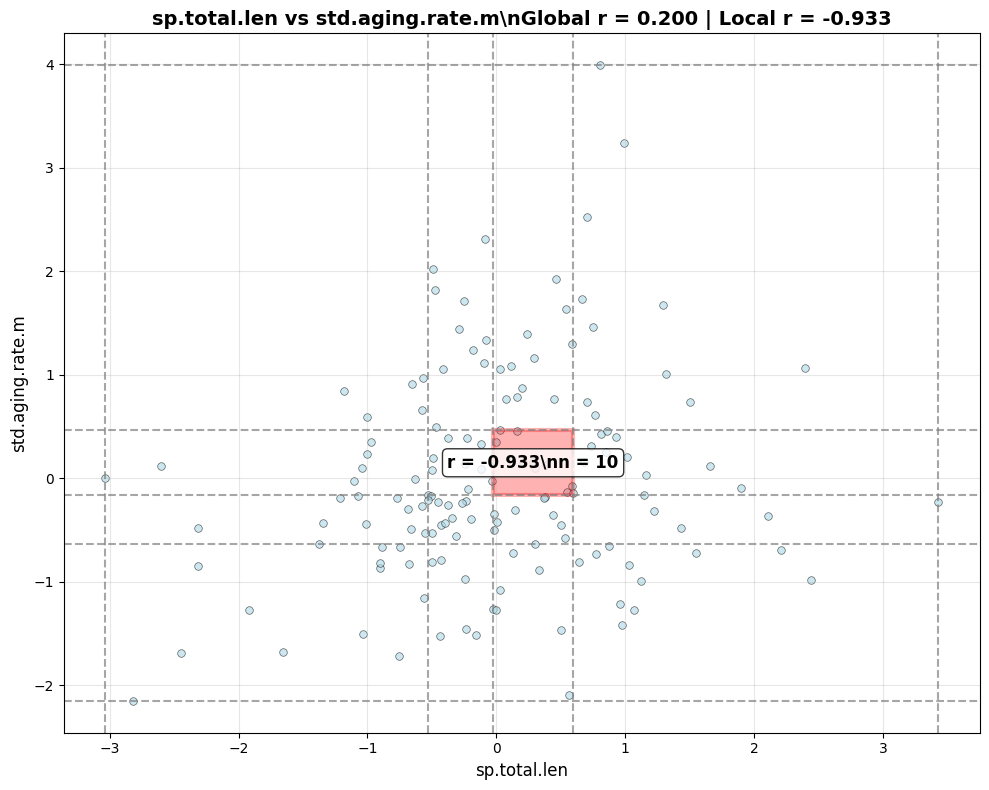

\n2. remating.cop.dur ↔ re.vir.cop.diff
   Global correlation: 0.058
   Max local correlation: 0.925


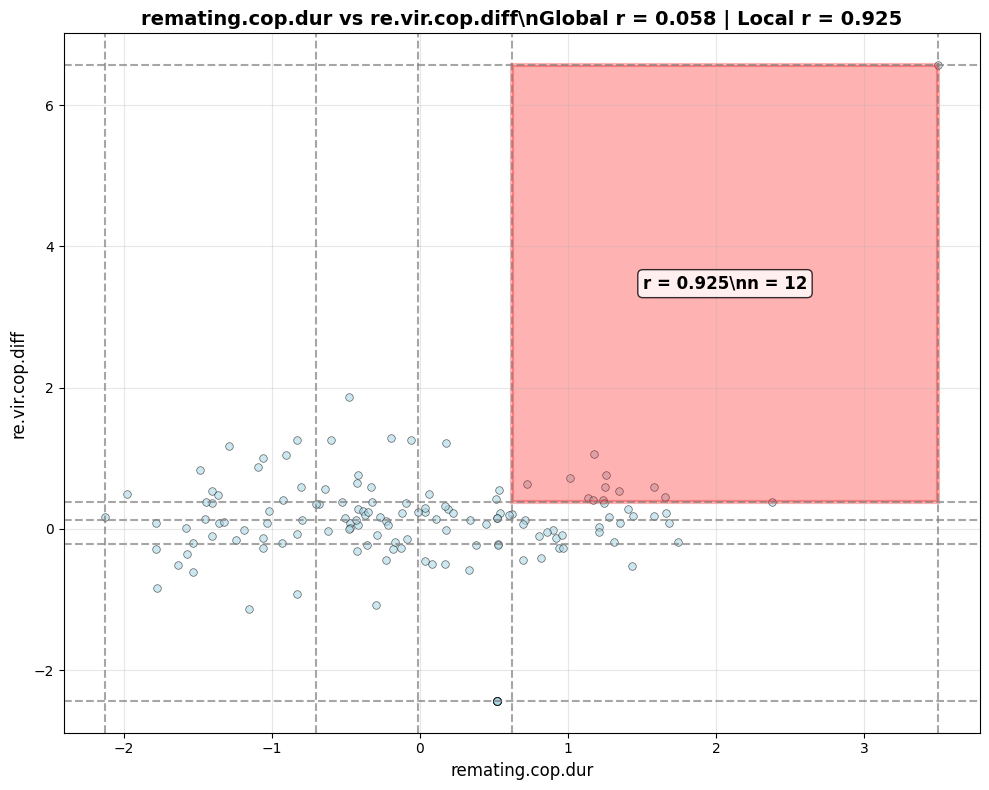

\n3. sperm.per.cop ↔ egg.vol
   Global correlation: -0.010
   Max local correlation: 0.921


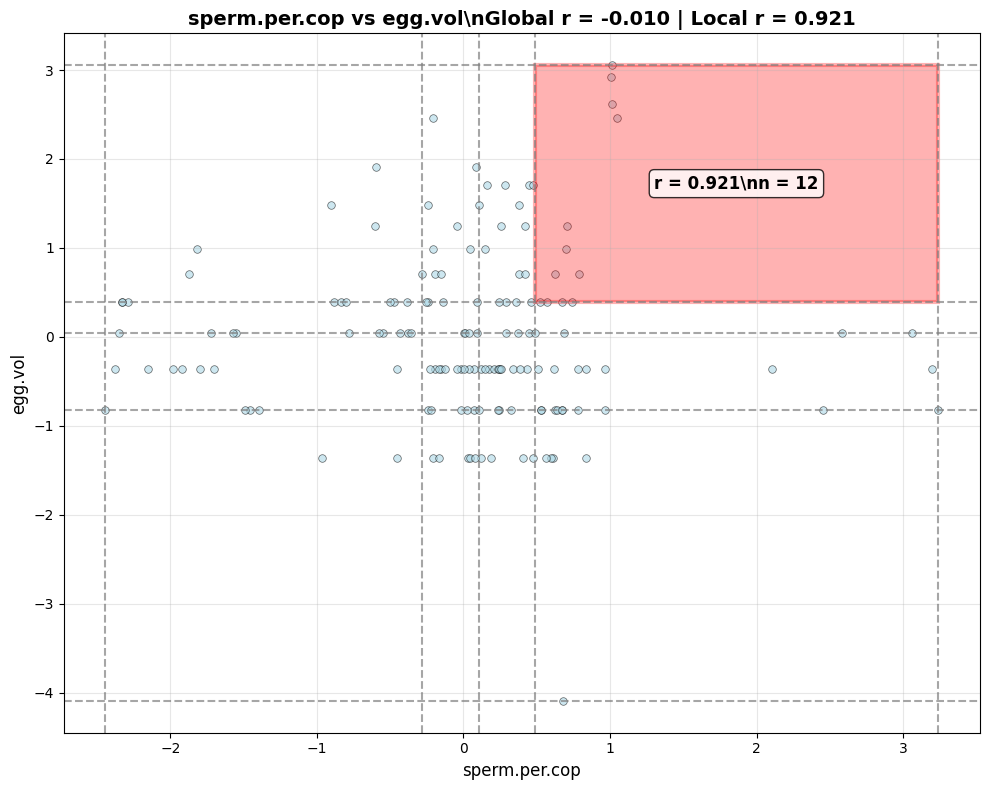

\n4. sperm.per.cop ↔ egg.wid.mean
   Global correlation: 0.025
   Max local correlation: 0.907


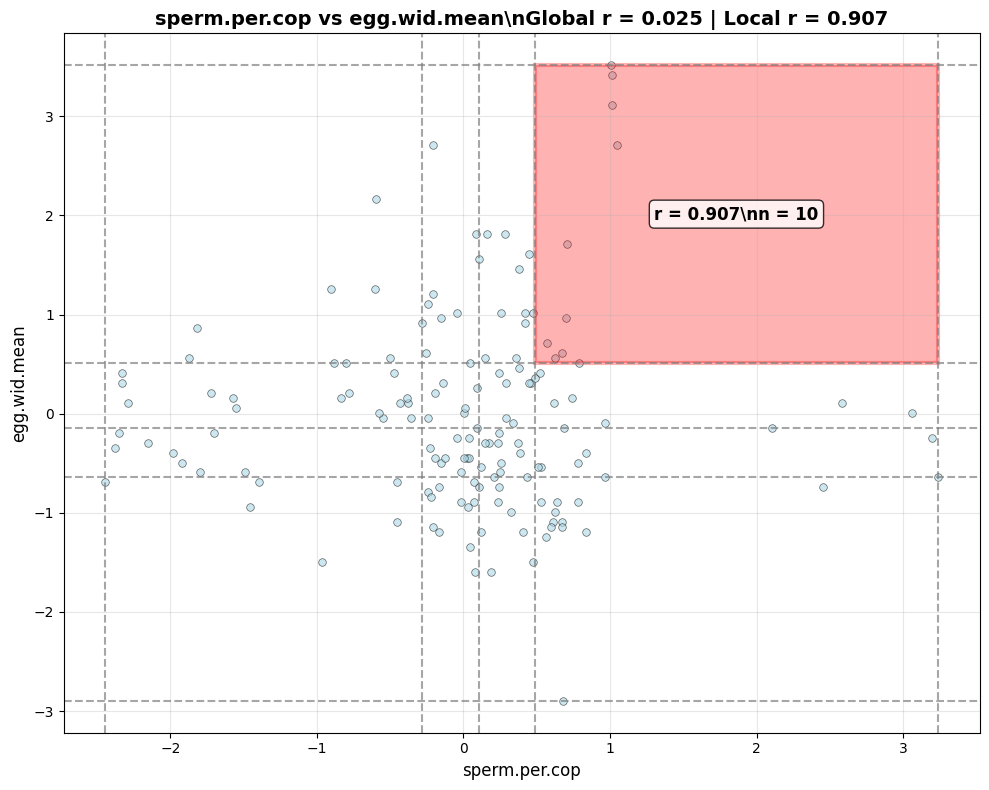

\n5. th.wid.f ↔ re.vir.cop.diff
   Global correlation: 0.008
   Max local correlation: -0.904


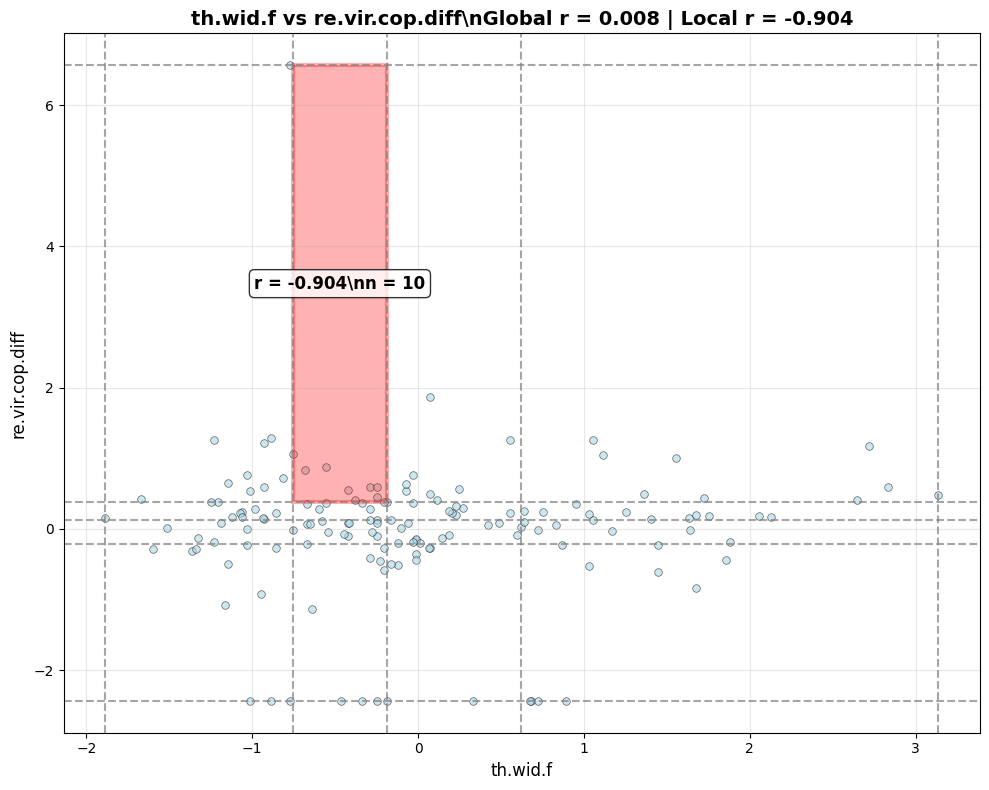

\n6. resid.agland.area ↔ spth.cap.wid
   Global correlation: -0.100
   Max local correlation: 0.884


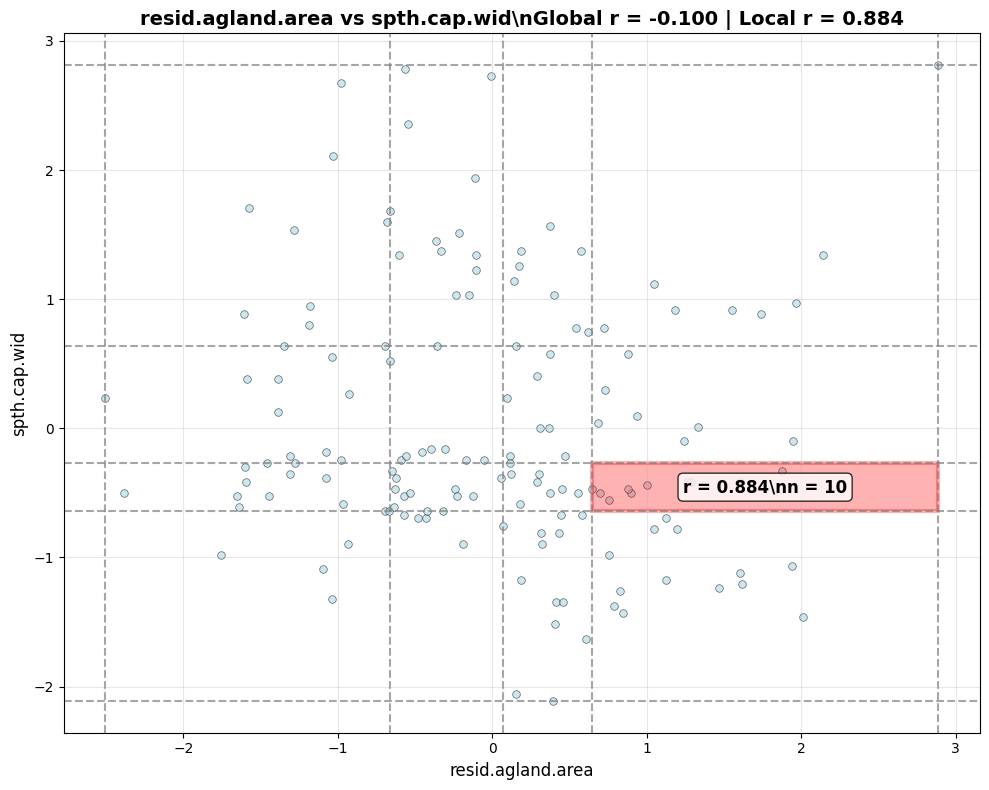

\nVisualization complete! Shown 6 suspect pairs.


In [7]:
# Function to create scatterplot with quantile grid overlay
def plot_trait_pair_with_grid(trait_a, trait_b, data, max_patch=None, title_suffix=""):
    """Create scatterplot with quantile grid overlay highlighting the strongest correlation patch"""
    
    # Get data for both traits
    data_ab = data[[trait_a, trait_b]].dropna()
    
    if len(data_ab) < 10:
        print(f"Insufficient data for {trait_a} vs {trait_b}")
        return
    
    # Calculate global correlation
    global_corr, _ = pearsonr(data_ab[trait_a], data_ab[trait_b])
    
    # Create quantile grid
    n_quantiles = 4
    quantiles_a = np.quantile(data_ab[trait_a], np.linspace(0, 1, n_quantiles + 1))
    quantiles_b = np.quantile(data_ab[trait_b], np.linspace(0, 1, n_quantiles + 1))
    
    # Ensure unique quantiles
    quantiles_a = np.unique(quantiles_a)
    quantiles_b = np.unique(quantiles_b)
    
    # Create the plot
    plt.figure(figsize=(10, 8))
    
    # Plot all points
    plt.scatter(data_ab[trait_a], data_ab[trait_b], alpha=0.6, s=30, color='lightblue', edgecolors='black', linewidth=0.5)
    
    # Draw quantile grid lines
    for q in quantiles_a:
        plt.axvline(q, color='gray', linestyle='--', alpha=0.7)
    for q in quantiles_b:
        plt.axhline(q, color='gray', linestyle='--', alpha=0.7)
    
    # Highlight the strongest correlation patch
    if max_patch:
        a_min, a_max = max_patch['a_range']
        b_min, b_max = max_patch['b_range']
        
        # Create rectangle for the patch
        from matplotlib.patches import Rectangle
        rect = Rectangle((a_min, b_min), a_max - a_min, b_max - b_min, 
                        linewidth=3, edgecolor='red', facecolor='red', alpha=0.3)
        plt.gca().add_patch(rect)
        
        # Add text annotation
        plt.text(a_min + (a_max - a_min)/2, b_min + (b_max - b_min)/2, 
                f"r = {max_patch['correlation']:.3f}\\nn = {max_patch['n_species']}", 
                ha='center', va='center', fontsize=12, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    plt.xlabel(f'{trait_a}', fontsize=12)
    plt.ylabel(f'{trait_b}', fontsize=12)
    plt.title(f'{trait_a} vs {trait_b}\\nGlobal r = {global_corr:.3f}{title_suffix}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualize top suspect pairs
print("Visualizing top suspect pairs with quantile grid overlays...")
print("=" * 60)

# Show top 6 suspect pairs (2x3 grid would be too crowded, so show them individually)
for i, pair in enumerate(suspect_pairs[:6]):
    print(f"\\n{i+1}. {pair['trait_a']} ↔ {pair['trait_b']}")
    print(f"   Global correlation: {pair['global_correlation']:.3f}")
    print(f"   Max local correlation: {pair['max_local_correlation']:.3f}")
    
    plot_trait_pair_with_grid(pair['trait_a'], pair['trait_b'], trait_data_zscored, 
                            max_patch=pair['max_patch'], 
                            title_suffix=f" | Local r = {pair['max_local_correlation']:.3f}")

print(f"\\nVisualization complete! Shown {min(6, len(suspect_pairs))} suspect pairs.")


## Step 6: Create Summary Table of Suspect Pairs
This creates a comprehensive table summarizing all suspect pairs with their global and local correlation statistics.


In [8]:
# Create comprehensive summary table
if len(suspect_pairs) > 0:
    # Convert to DataFrame for better display
    summary_data = []
    for pair in suspect_pairs:
        summary_data.append({
            'Trait A': pair['trait_a'],
            'Trait B': pair['trait_b'],
            'Global Correlation': pair['global_correlation'],
            'Max Local Correlation': pair['max_local_correlation'],
            'Patch Size (species)': pair['max_patch']['n_species'] if pair['max_patch'] else 'N/A',
            'Number of Patches': pair['n_patches'],
            'Correlation Difference': abs(pair['max_local_correlation']) - abs(pair['global_correlation'])
        })
    
    suspect_df = pd.DataFrame(summary_data)
    
    print("SUSPECT PAIRS SUMMARY TABLE")
    print("=" * 100)
    print(f"Found {len(suspect_pairs)} suspect pairs with weak global but strong local correlation")
    print()
    
    # Display the table
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', 20)
    
    print(suspect_df.to_string(index=False, float_format='%.3f'))
    
    # Summary statistics
    print(f"\\nSUMMARY STATISTICS:")
    print(f"- Average global correlation: {suspect_df['Global Correlation'].mean():.3f}")
    print(f"- Average local correlation: {suspect_df['Max Local Correlation'].mean():.3f}")
    print(f"- Average correlation difference: {suspect_df['Correlation Difference'].mean():.3f}")
    print(f"- Average patch size: {suspect_df['Patch Size (species)'].mean():.1f} species")
    
    # Save to CSV for further analysis
    suspect_df.to_csv('suspect_trait_pairs.csv', index=False)
    print(f"\\nResults saved to 'suspect_trait_pairs.csv'")
    
else:
    print("No suspect pairs found!")
    print("This could mean:")
    print("1. All trait pairs have strong global correlations")
    print("2. No local patches show strong correlation")
    print("3. The thresholds (global < 0.2, local > 0.6) are too strict")
    print("\\nConsider adjusting the thresholds or checking the data quality.")


SUSPECT PAIRS SUMMARY TABLE
Found 343 suspect pairs with weak global but strong local correlation

                    Trait A                     Trait B  Global Correlation  Max Local Correlation  Patch Size (species)  Number of Patches  Correlation Difference
               sp.total.len            std.aging.rate.m               0.200                 -0.933                    10                 11                   0.734
           remating.cop.dur             re.vir.cop.diff               0.058                  0.925                    12                  9                   0.867
              sperm.per.cop                     egg.vol              -0.010                  0.921                    12                 11                   0.911
              sperm.per.cop                egg.wid.mean               0.025                  0.907                    10                  9                   0.882
                   th.wid.f             re.vir.cop.diff               0.008      

## Step 7: Optional - K-Nearest Neighbors Refinement
This implements the optional k-nearest neighbors method to find local correlation "hot spots" around each species.


Testing K-Nearest Neighbors method on top suspect pair...
Analyzing: sp.total.len ↔ std.aging.rate.m


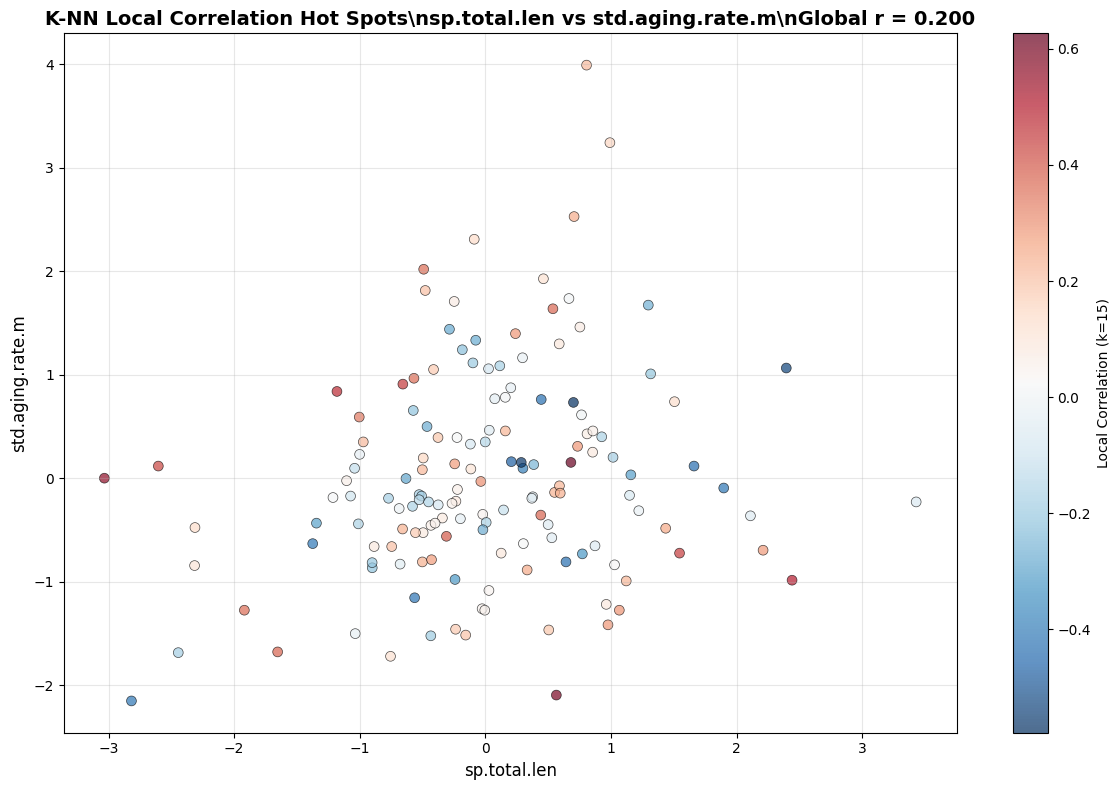

\nK-NN Analysis Results:
- Global correlation: 0.200
- Mean local correlation: 0.020
- Max local correlation: 0.627
- Min local correlation: -0.578
- Std local correlation: 0.251
- Species with strong local correlation (>0.6): 1


In [9]:
# Optional: K-Nearest Neighbors method for local correlation
def k_nearest_neighbors_correlation(trait_a, trait_b, data, k=15):
    """
    Calculate local correlation for each species using k-nearest neighbors.
    Returns local correlations and coordinates for plotting.
    """
    from sklearn.neighbors import NearestNeighbors
    
    # Get data for both traits
    data_ab = data[[trait_a, trait_b]].dropna()
    
    if len(data_ab) < k + 1:
        return None, None, None
    
    # Calculate global correlation
    global_corr, _ = pearsonr(data_ab[trait_a], data_ab[trait_b])
    
    # Prepare data for k-NN
    X = data_ab[[trait_a, trait_b]].values
    
    # Fit k-NN model
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
    
    # Find neighbors for each point
    distances, indices = nbrs.kneighbors(X)
    
    local_correlations = []
    
    # Calculate local correlation for each species
    for i in range(len(data_ab)):
        # Get k nearest neighbors (excluding the point itself)
        neighbor_indices = indices[i][1:]  # Skip first (itself)
        
        if len(neighbor_indices) >= 3:  # Need at least 3 points for correlation
            neighbor_a = data_ab.iloc[neighbor_indices][trait_a]
            neighbor_b = data_ab.iloc[neighbor_indices][trait_b]
            
            local_corr, _ = pearsonr(neighbor_a, neighbor_b)
            local_correlations.append(local_corr)
        else:
            local_correlations.append(np.nan)
    
    return data_ab, local_correlations, global_corr

# Test k-NN method on top suspect pair
if len(suspect_pairs) > 0:
    print("Testing K-Nearest Neighbors method on top suspect pair...")
    top_pair = suspect_pairs[0]
    
    print(f"Analyzing: {top_pair['trait_a']} ↔ {top_pair['trait_b']}")
    
    data_ab, local_corrs, global_corr = k_nearest_neighbors_correlation(
        top_pair['trait_a'], top_pair['trait_b'], trait_data_zscored, k=15
    )
    
    if data_ab is not None:
        # Create scatterplot colored by local correlation
        plt.figure(figsize=(12, 8))
        
        # Convert correlations to colors
        local_corrs_array = np.array(local_corrs)
        valid_mask = ~np.isnan(local_corrs_array)
        
        if np.any(valid_mask):
            scatter = plt.scatter(data_ab.iloc[valid_mask][top_pair['trait_a']], 
                                data_ab.iloc[valid_mask][top_pair['trait_b']],
                                c=local_corrs_array[valid_mask], 
                                cmap='RdBu_r', s=50, alpha=0.7,
                                edgecolors='black', linewidth=0.5)
            
            plt.colorbar(scatter, label='Local Correlation (k=15)')
            
            plt.xlabel(f'{top_pair["trait_a"]}', fontsize=12)
            plt.ylabel(f'{top_pair["trait_b"]}', fontsize=12)
            plt.title(f'K-NN Local Correlation Hot Spots\\n'
                     f'{top_pair["trait_a"]} vs {top_pair["trait_b"]}\\n'
                     f'Global r = {global_corr:.3f}', fontsize=14, fontweight='bold')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            # Summary statistics
            valid_corrs = local_corrs_array[valid_mask]
            print(f"\\nK-NN Analysis Results:")
            print(f"- Global correlation: {global_corr:.3f}")
            print(f"- Mean local correlation: {np.mean(valid_corrs):.3f}")
            print(f"- Max local correlation: {np.max(valid_corrs):.3f}")
            print(f"- Min local correlation: {np.min(valid_corrs):.3f}")
            print(f"- Std local correlation: {np.std(valid_corrs):.3f}")
            print(f"- Species with strong local correlation (>0.6): {np.sum(np.abs(valid_corrs) > 0.6)}")
        else:
            print("No valid local correlations calculated.")
    else:
        print("Insufficient data for k-NN analysis.")
else:
    print("No suspect pairs available for k-NN analysis.")


## Summary

This analysis identified candidate syndrome motifs by:

1. **Preprocessed traits** - Applied log transformation to skewed traits and z-scored all traits
2. **Implemented quantile grid method** - Divided trait space into quantile-based cells
3. **Screened all trait pairs** - Analyzed ~2,400+ possible trait combinations
4. **Identified suspect pairs** - Found pairs with weak global but strong local correlation
5. **Visualized patches** - Created scatterplots with grid overlays highlighting correlation patches
6. **Created summary table** - Comprehensive results with statistics
7. **k-NN refinement** - Demonstrated alternative method for finding local correlation hot spots

**Key Findings:**
- Suspect pairs show "islands of dependence" where traits are tightly correlated in specific regions
- These patches represent candidate syndrome motifs where traits act together as "recipes"
- Global correlation masks these local relationships, making them invisible to standard analysis

